In [1]:
# 将谷歌硬盘安装到CoLab虚拟机上
# from google.colab import drive
# drive.mount('/content/drive')

# TODO:在驱动器中输入保存解压缩文件的文件夹名
# 工作分配文件夹, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# 现在我们已经安装了您的驱动器，这确保了Python解释器可以从中加载Python文件。
import sys
sys.path.append('D:/CodeWorkspace/{}'.format(FOLDERNAME))

# 这会将CIFAR-10数据集下载到您的驱动器（如果它还不存在）。
%cd D:/CodeWorkspace/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd D:/CodeWorkspace/$FOLDERNAME

D:\CodeWorkspace\cs231n\assignments\assignment1\cs231n\datasets
�(u�N  L i n u x   �v  W i n d o w s   P[�|�~�l	g�]�[ň�vR�SHr0
 
 
 �S�N�Ǐ���  M i c r o s o f t   S t o r e   eg�[ňR�SHr: 
 
 
 h t t p s : / / a k a . m s / w s l s t o r e 
 
 
 
D:\CodeWorkspace\cs231n\assignments\assignment1


# K临近算法练习 (kNN)

完成并提交此已完成的工作表（包括其输出和工作表之外的任何支持代码）和作业提交。有关详细信息，请参阅课程网站上的[作业页面](http://vision.stanford.edu/teaching/cs231n/assignments.html)

kNN 分类器由两个阶段组成：

- 在训练过程中，分类器获取训练数据并简单地记住它
- 在测试过程中，kNN 通过与所有训练图像进行比较并传输 k 个最相似的训练样本的标签来对每个测试图像进行分类
- k 的值是交叉验证的

在本练习中，您将实施这些步骤，并了解基本的图像分类管道、交叉验证，并熟练编写高效的矢量化代码。

In [2]:
# 为此笔记本运行一些安装代码。
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# 这有点神奇，可以使matplotlib图形在线显示在笔记本中，而不是新窗口中。
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置绘图的默认大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 一些更神奇的让笔记本电脑重新加载外部python模块；
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# 加载原始CIFAR-10数据。
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# 清理变量以防止多次加载数据（这可能会导致内存问题）
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 作为健全性检查，我们打印出训练和测试数据的大小。
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


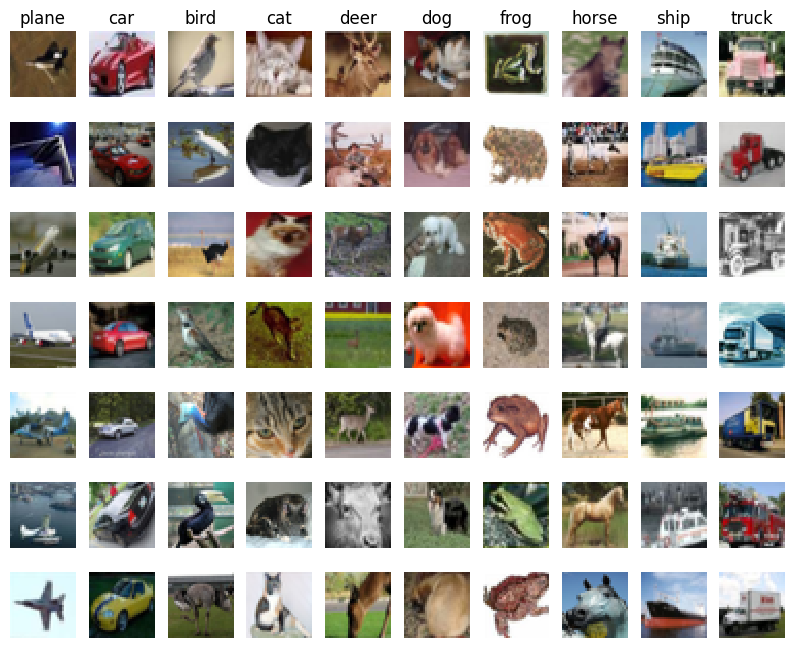

In [4]:
# 将数据集中的一些示例可视化。
# 展示了每个类别的一些训练图像示例。
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
# 遍历每个类别并显示其中的一部分样本
for y, cls in enumerate(classes):
    # 找到训练集中属于当前类别的样本的索引
    idxs = np.flatnonzero(y_train == y) # flatnonzero返回布尔数组中非零元素（True）的索引
    # 从索引中随机选择不重复的样本数量
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    # 遍历选择的索引并显示图像
    for i, idx in enumerate(idxs):
        # 遍历选择的索引并显示图像
        plt_idx = i * num_classes + y + 1
        # 为每个图像创建一个子图
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        # 为每个图像创建一个子图
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# 对数据进行子采样，以便在本练习中更高效地执行代码
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# 将图像数据重塑为行
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
from cs231n.classifiers import KNearestNeighbor

# 创建一个kNN分类器实例。记住，训练kNN分类器是一个技巧：分类器只记住数据，不进行进一步处理
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

现在，我们想使用 kNN 分类器对测试数据进行分类。回想一下，我们可以将此过程分解为两个步骤：

1. 首先，我们必须计算所有测试样本和所有训练样本之间的距离。
2. 给定这些距离，对于每个测试示例，我们找到 k 个最近的示例，并让它们投票支持标签

让我们从计算所有训练样本和测试样本之间的距离矩阵开始。例如，如果有 **Ntr** 训练示例和 **Nte** 测试示例，则此阶段应生成 **Nte x Ntr** 矩阵，其中每个元素 (i,j) 是第 i 个测试和第 j 个训练示例之间的距离。

**注意：对于我们要求您在此笔记本中实现的三个距离计算，您不能使用 numpy 提供的 np.linalg.norm（） 函数。**

首先，打开 `cs231n/classifiers/k_nearest_neighbor.py` 并实现对所有（测试、训练）示例使用（非常低效的）双循环的函数 `compute_distances_two_loops` ，并一次计算一个元素的距离矩阵。

In [7]:
# 打开cs231n/classifiers/k_nearest_neighbor.py并实现compute_distances_two_loops。

# 测试你的实现：
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


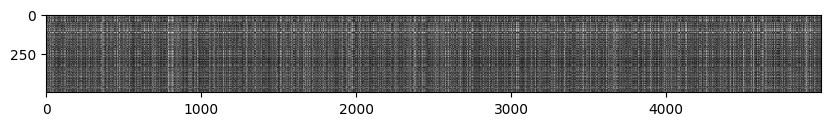

In [8]:
# 我们可以可视化距离矩阵：每一行都是一个测试示例，以及它到训练示例的距离
plt.imshow(dists, interpolation='none')
plt.show()

**内联问题 1**

请注意距离矩阵中的结构化模式，其中某些行或列明显更亮。（请注意，在默认配色方案中，黑色表示低距离，而白色表示高距离。）

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

Your Answer:
1. 是什么导致了一行中的数据明亮  
从图像中外面可以看到这个图像是大小为500*5000的一个图像，对于第i行而言，就等于第i个测试图像，与所有训练图像的L2距离，明亮就说明L2距离比较大，也就是偏差比较大
2. 是什么导致了一列中的数据明亮  
同上，只不过这次是对于第j个训练数据而言，与500个测试数据的L2举例比较大



In [9]:
# 现在实现函数predict_labels并运行以下代码：
# 我们使用k=1（这是最近邻）。
y_test_pred = classifier.predict_labels(dists, k=1)

# 计算并打印正确预测示例的分数
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


你应该期望看到大致 27% 的准确性。现在让我们尝试一个更大的 k ，比如说 k = 5 ：

In [10]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 144 / 500 correct => accuracy: 0.288000


您应该期望看到比 `k = 1` 好的性能。

In [11]:
# 现在让我们通过使用带有一个循环的部分矢量化来加快距离矩阵的计算。
# 实现函数compute_dinstance_one_loop并运行下面的代码：
dists_one = classifier.compute_distances_one_loop(X_test)

# 为了确保我们的矢量化实现是正确的，我们确保它与本地的实现一致。
# 有很多方法可以决定两个矩阵是否相似；
# 其中最简单的是弗罗贝尼乌斯范数。在你以前没有见过的情况下，两个矩阵的Frobenius范数是所有元素差的平方和的平方根；
# 换句话说，将矩阵重塑为向量，并计算它们之间的欧几里得距离。
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [12]:
# 现在在compute_dinstances_no_loops中实现完全矢量化的版本，并运行代码
dists_two = classifier.compute_distances_no_loops(X_test)

# 检查距离矩阵是否与我们之前计算的距离矩阵一致：
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [13]:
# 让我们比较一下实现的速度
def time_function(f, *args):
    """
    调用带有args的函数f，并返回执行所用的时间（以秒为单位）。
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# 使用完全矢量化的实现，您应该可以看到明显更快的性能！
# 注意：根据你使用的机器，当你从两个循环到一个循环时，你可能看不到加速，甚至可能看到减速。

Two loop version took 17.764298 seconds
One loop version took 31.933734 seconds
No loop version took 0.113812 seconds


### 交叉验证

我们已经实现了 k-最近邻分类器，但我们任意设置了值 k = 5。现在，我们将通过交叉验证确定此超参数的最佳值。

In [14]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                 #
# 将训练数据拆分为多个文件。
# 分割后，X_train_folds和y_train_folds应分别为长度num_folds的列表，其中y_train_folds[i]是X_train_foolds[i]中点的标签向量。
# 所谓交叉验证：就是将训练数据拆分为5个文件，拿出其中一个作为验证集（test测试集作为最后使用）
# Hint: 查找numpy.array_split函数。                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 一个字典用来保存我们在运行交叉验证时发现的不同k值的准确性。
# 在运行交叉验证后，k_to_accuracies[k]应该是一个长度num_folds列表，其中给出了我们在使用k的值时发现的不同的精度值。
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# 进行k次交叉验证以找到k的最佳值。        #
# 对于k的每个可能值，运行k-nearest-neighbor算法num_folds次，在每种情况下，您都使用除一个文件外的所有文件作为训练数据，并使用最后一个文件作为验证集。   #
# 将k的所有文件和所有值的精度存储在k_to_accurces字典中。                                  #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

classifier = KNearestNeighbor()
flod_lgh = X_train.shape[0] // num_folds
for k in k_choices:
  for i in range(num_folds):
    x_train_sub = np.append(X_train[:flod_lgh*i,:], X_train[flod_lgh*(i+1):, :], axis=0)
    y_train_sub = np.append(y_train[:flod_lgh*i], y_train[flod_lgh*(i+1):], axis=0)
    classifier.train(x_train_sub, y_train_sub)
    y_test_pred = classifier.predict(X_train_folds[i], k = k)

    num_correct = np.sum(y_test_pred == y_train_folds[i])
    accuracy = float(num_correct) / flod_lgh
    k_to_accuracies.setdefault(k, []).append(accuracy) # 对每个k加入它所有的精度值
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# 打印计算的准确度
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.257000
k = 3, accuracy = 0.263000
k = 3, accuracy = 0.273000
k = 3, accuracy = 0.282000
k = 3, accuracy = 0.270000
k = 5, accuracy = 0.263000
k = 5, accuracy = 0.274000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.297000
k = 5, accuracy = 0.288000
k = 8, accuracy = 0.271000
k = 8, accuracy = 0.298000
k = 8, accuracy = 0.284000
k = 8, accuracy = 0.301000
k = 8, accuracy = 0.291000
k = 10, accuracy = 0.270000
k = 10, accuracy = 0.305000
k = 10, accuracy = 0.288000
k = 10, accuracy = 0.295000
k = 10, accuracy = 0.286000
k = 12, accuracy = 0.268000
k = 12, accuracy = 0.304000
k = 12, accuracy = 0.286000
k = 12, accuracy = 0.290000
k = 12, accuracy = 0.276000
k = 15, accuracy = 0.259000
k = 15, accuracy = 0.307000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.294000
k = 15, accuracy = 0.281000
k = 20, accuracy = 0.267000
k = 20, accu

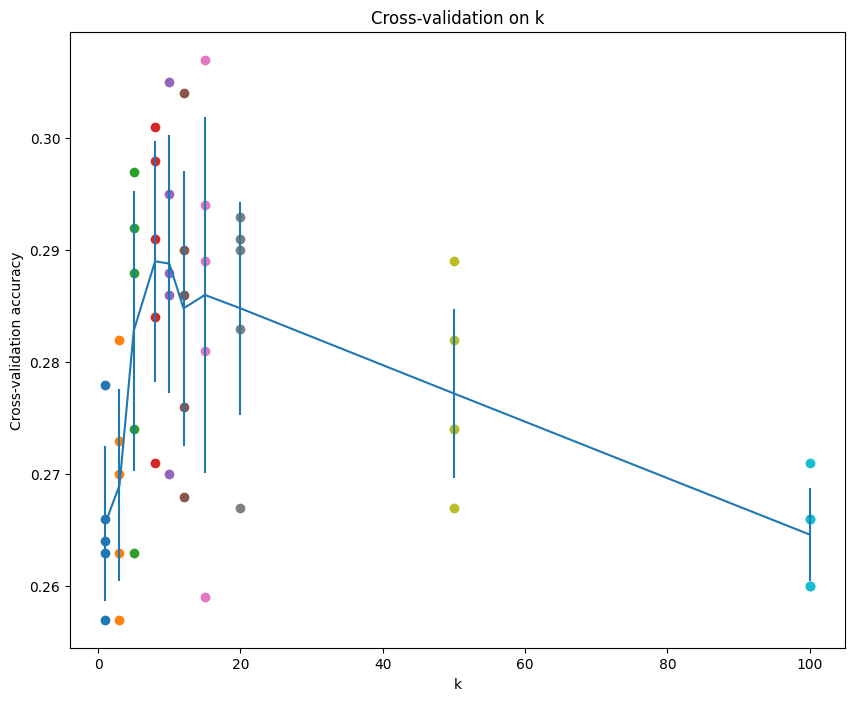

In [15]:
# 绘制原始观测结果
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# 用与标准偏差相对应的误差条绘制趋势线
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [19]:
# 基于上述交叉验证结果，选择k的最佳值，使用所有训练数据重新训练分类器，并在测试数据上进行测试。
# 你应该能够在测试数据上获得28%以上的准确率。
best_k = 8

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# 计算并展示准确度
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 148 / 500 correct => accuracy: 0.296000
